In [1]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

from sklearn.metrics import f1_score
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
MAX_LEN = 100
BATCH = 16
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
EPOCHS = 50
LEARNING_RATE = 0.01
THRESHOLD = 0.2
DROPOUT_RATE = 0.5
WEIGHT_DECAY = 0.1
MODE = 'min'
PATIENCE = 2
FACTOR = 0.5
VERBOSE = True

In [3]:
df = pd.read_csv('D:/julixus/MEISD/meisd_project/data/MEISD_text.csv')
# Zamień wartości na liczby całkowite
df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce').fillna(0)
df['intensity2'] = pd.to_numeric(df['intensity2'], errors='coerce').fillna(0)
df['intensity3'] = pd.to_numeric(df['intensity3'], errors='coerce').fillna(0)

# Zamień wartości zawierające tylko białe znaki lub '`', 'neu', 'po' na NaN
df['intensity'] = df['intensity'].replace(r'^\s*$', np.nan, regex=True)
df['intensity'] = df['intensity'].replace(['`', 'neu', 'po'], np.nan)
df['intensity2'] = df['intensity2'].replace(r'^\s*$', np.nan, regex=True)
df['intensity2'] = df['intensity2'].replace(['`', 'neu', 'po'], np.nan)
df['intensity3'] = df['intensity3'].replace(r'^\s*$', np.nan, regex=True)
df['intensity3'] = df['intensity3'].replace(['`', 'neu', 'po'], np.nan)

# Użyj forward fill, aby uzupełnić brakujące wartości poprzedzającą wartością
df['intensity'] = df['intensity'].ffill()
df['intensity2'] = df['intensity2'].ffill()
df['intensity3'] = df['intensity3'].ffill()

# Usuń znaki niebędące cyframi (np. '`') za pomocą wyrażeń regularnych
df['intensity'] = df['intensity'].replace(r'\D', '', regex=True).astype(int)  # Usuwa wszystko, co nie jest cyfrą
df['intensity2'] = df['intensity2'].replace(r'\D', '', regex=True).astype(int)
df['intensity3'] = df['intensity3'].replace(r'\D', '', regex=True).astype(int)

missing_count = df['intensity'].isna().sum()
print(f"Liczba braków w kolumnie 'intensity': {missing_count}")
unique_values = df['intensity'].unique()
print(f"Unikalne wartości w kolumnie 'intensity': {unique_values}")

Liczba braków w kolumnie 'intensity': 0
Unikalne wartości w kolumnie 'intensity': [0 1 2 3]


In [4]:
columns = ['Utterances', 'dialog_ids', 'uttr_ids', 'intensity', 'intensity2', 'intensity3']
df = df[columns].copy()

In [5]:
first_25_data = []
last_25_data = []

def process_group(group):
    num_rows = len(group)
    quarter_size = max(1, num_rows // 4)

    # First 25%
    first_25 = group.iloc[:quarter_size]
    primary_intensity = max(
        group['intensity'].iloc[0],
        group['intensity2'].iloc[0],
        group['intensity3'].iloc[0]
    )
    first_25 = first_25.assign(primary_intensity=primary_intensity)

    # Last 25%
    last_25 = group.iloc[-quarter_size:]
    final_intensity = max(
        group['intensity'].iloc[-1],
        group['intensity2'].iloc[-1],
        group['intensity3'].iloc[-1]
    )
    last_25 = last_25.assign(final_intensity=final_intensity)

    first_25_data.append(first_25)
    last_25_data.append(last_25)

df.groupby('dialog_ids').apply(process_group)

first_25_df = pd.concat(first_25_data).reset_index(drop=True)
last_25_df = pd.concat(last_25_data).reset_index(drop=True)

grouped_first_25 = first_25_df.groupby('dialog_ids').agg({
    'Utterances': ' '.join,
    'primary_intensity': 'first'
}).reset_index()

grouped_last_25 = last_25_df.groupby('dialog_ids').agg({
    'Utterances': ' '.join,
    'final_intensity': 'first'
}).reset_index()

df = grouped_first_25.drop(df.columns[0], axis=1)

# grouped_first_25.to_csv('first_25_percent.csv', index=False)
# grouped_last_25.to_csv('last_25_percent.csv', index=False)

C:\Users\Julix\AppData\Local\Temp\ipykernel_2928\2868896721.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('dialog_ids').apply(process_group)


In [6]:
grouped_first_25.head()

,dialog_ids,Utterances,primary_intensity
0,1,look around you say hello to your competition ...,0
1,2,"i'm george o'malley uh, we met at the mixer. y...",2
2,3,seattle is surrounded by water on three sides ...,1
3,4,yes no other reason? just a favor for an old p...,1
4,5,if he doesn't respond to these tests in the ne...,2


In [7]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [8]:
grouped_last_25.head()

,dialog_ids,Utterances,final_intensity
0,1,"you're cristina, right? - patton, monroe which...",2
1,2,i have five rules. memorize them rule number o...,0
2,3,"""i'm your sister, i'm your daughter."" you're s...",0
3,4,just be quick about it you're the one that's s...,3
4,5,people do wake up. that's why we do a series o...,1


In [9]:
token_lens = []

for txt in grouped_first_25['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


C:\Users\Julix\AppData\Local\Temp\ipykernel_2928\1466372787.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

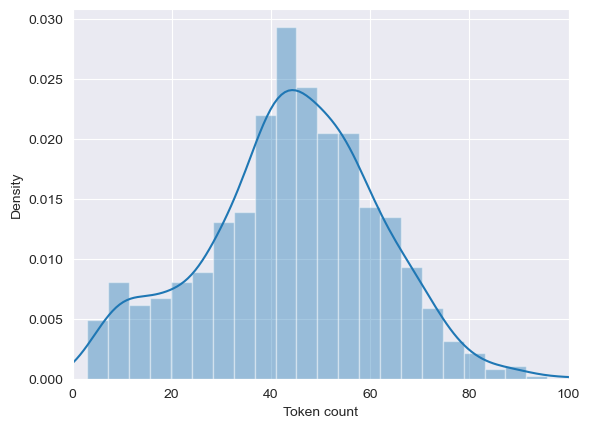

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')

In [11]:
df = grouped_first_25

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df['primary_intensity'].astype(int).values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long),
            'utterances': utterances
        }


In [13]:
from sklearn.model_selection import train_test_split

# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [14]:
print(f"Original train size: {df.shape}")
print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (1124, 3)
Validation size: (169, 3), Test size: (169, 3)


In [15]:
label_frequencies = df_train['primary_intensity'].value_counts()
label_frequencies_percent = df_train['primary_intensity'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

primary_intensity
2    36.259542
1    25.954198
3    24.045802
0    13.740458
Name: proportion, dtype: float64
primary_intensity
2    285
1    204
3    189
0    108
Name: count, dtype: int64


In [16]:
target_list = list(df.columns)
target_list = target_list[1:]
target_list

['Utterances', 'primary_intensity']

In [17]:
class BERT_IntensityClass(torch.nn.Module):
    def __init__(self, bert_model):
        super(BERT_IntensityClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(p=DROPOUT_RATE) #0.5
        self.linear = torch.nn.Linear(bert_model.config.hidden_size, 4)
        #self.softmax = nn.Softmax(dim=1) #remove for sentiment analysis
        #CrossEntropyLoss automatycznie aplikuje funkcję softmax, więc nie ma potrzeby używać Softmax w modelu.


    def forward(self, input_ids, attn_mask, token_type_ids=None):
        output = self.bert_model(input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids)
        #pooler_output = self.pooler_output
        dropout_output = self.dropout(output.pooler_output)
        linear_output = self.linear(dropout_output)
        #output = self.dropout(linear_output)
        # output = self.softmax(linear_output)
        return linear_output

In [18]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BERT_IntensityClass(bert_model)
model.to(device)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [20]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [21]:
data = next(iter(train_data_loader))
outputs = model(data["input_ids"], attn_mask=data["attention_mask"])
print(outputs)

tensor([[ 0.2745, -0.3975, -0.4561,  0.1284],
        [-0.5178, -0.0034, -1.5542, -0.1290],
        [ 0.2207,  0.0687, -0.6029, -0.3290],
        [-0.0819,  0.6714, -0.2760, -0.2369],
        [-0.5242, -0.2347, -1.2079,  0.2017],
        [ 0.3850, -0.2903,  0.1076, -0.6419],
        [ 0.5396, -0.0126, -0.6160,  0.3253],
        [-0.4604,  0.0271, -0.0479, -0.4436],
        [ 0.4459,  0.4220, -0.2709,  0.3940],
        [-0.4022,  0.2774, -0.6280, -1.0219],
        [ 0.2102,  0.3978, -1.1006, -0.1735],
        [-0.1934,  0.6242, -0.4582, -0.7374],
        [-0.3693,  0.0213, -0.9770,  0.3121],
        [-0.1005,  0.1304, -1.0401,  0.2316],
        [-0.8358, -0.0931, -0.8491,  0.5234],
        [-0.6378,  0.7660, -0.7083, -0.3387]], grad_fn=<AddmmBackward0>)


In [22]:
test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                                  max_length=50,
                                  truncation=True,
                                  padding="max_length",
                                  return_attention_mask=True,
                                  return_tensors="pt")


In [23]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

In [24]:
class_distribution = df_train['primary_intensity'].value_counts(normalize=True)
total_samples = sum(class_distribution)
class_weights = [total_samples / count for count in class_distribution]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([2.7579, 3.8529, 4.1587, 7.2778])

In [25]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

In [26]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs')

In [27]:
from transformers import AdamW, get_linear_schedule_with_warmup

#EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE, patience=PATIENCE, factor=FACTOR, verbose=VERBOSE)

D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(ids, mask, token_type_ids)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        # Collect predictions and labels for F1-score
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        loop.set_postfix(batch_loss=loss.item())

    # Calculate F1-score for training data
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1

In [29]:
def eval_model(validation_loader, model, epoch):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate predictions and accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Logowanie do TensorBoard
    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1

In [30]:
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io

history = defaultdict(list)
best_accuracy = 0
writer = SummaryWriter(log_dir='logs')

def plot_confusion_matrix(cm, class_names, epoch):
    figure = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix at Epoch {epoch}')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = torch.tensor(np.frombuffer(buf.getvalue(), dtype=np.uint8)).float()
    writer.add_image('Confusion Matrix', image, epoch)

    plt.close(figure)  

In [31]:
# Główna pętla treningowa
# %%time
history = defaultdict(list)
best_f1 = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Sprawdzenie najlepszej F1 i zapisanie modelu
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    scheduler.step(val_loss)  # Tuning LR

writer.close()

Epoch 1/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3883 | Train accuracy 0.2850 | Train F1 0.2560
Val loss 1.3192 | Val accuracy 0.2959 | Val F1 0.1732
Saved new best model.
Epoch 2/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3786 | Train accuracy 0.2875 | Train F1 0.2526
Val loss 1.2668 | Val accuracy 0.3491 | Val F1 0.2597
Saved new best model.
Epoch 3/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3892 | Train accuracy 0.2926 | Train F1 0.2640
Val loss 1.3075 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 4/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3884 | Train accuracy 0.2812 | Train F1 0.2387
Val loss 1.3157 | Val accuracy 0.3077 | Val F1 0.1547
Epoch 5/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3501 | Train accuracy 0.3015 | Train F1 0.2638
Val loss 1.2745 | Val accuracy 0.3136 | Val F1 0.2260
Epoch 6/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3540 | Train accuracy 0.2888 | Train F1 0.2411
Val loss 1.3894 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 7/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3281 | Train accuracy 0.3041 | Train F1 0.2663
Val loss 1.3083 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 8/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3492 | Train accuracy 0.2824 | Train F1 0.2448
Val loss 1.2545 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 9/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3447 | Train accuracy 0.2799 | Train F1 0.2418
Val loss 1.2536 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 10/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3239 | Train accuracy 0.2812 | Train F1 0.2396
Val loss 1.2526 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 11/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3160 | Train accuracy 0.2863 | Train F1 0.2379
Val loss 1.2482 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 12/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3312 | Train accuracy 0.2557 | Train F1 0.2109
Val loss 1.2480 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 13/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3366 | Train accuracy 0.2735 | Train F1 0.2154
Val loss 1.2739 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 14/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3317 | Train accuracy 0.2799 | Train F1 0.2465
Val loss 1.2561 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 15/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3102 | Train accuracy 0.2481 | Train F1 0.1979
Val loss 1.2770 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 16/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3049 | Train accuracy 0.2875 | Train F1 0.2251
Val loss 1.2507 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 17/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3045 | Train accuracy 0.2812 | Train F1 0.2317
Val loss 1.2466 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 18/50


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 